In [1]:
!pip install librosa
!pip install tensorflow

In [2]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
import pandas as pd
audiodata='/Users/dk20abk/OneDrive - University of Hertfordshire/Urbansound8k/Audio'
metadata_file_path='/Users/dk20abk/OneDrive - University of Hertfordshire/Urbansound8k/Metadata/UrbanSound8K.csv'
metadata=pd.read_csv('/Users/dk20abk/OneDrive - University of Hertfordshire/Urbansound8k/Metadata/UrbanSound8K.csv')
print("shape of the metadata =",metadata.shape)
metadata.head()

shape of the metadata = (8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [10]:
# Extracting MFCC's For every audio file
max_pad_len=174
def feature_extraction(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width=max_pad_len - mfccs_features.shape[1]
    mfccs_scaled_features = np.pad(mfccs_features,pad_width=((0,0), (0,pad_width)),mode='constant')
    
    return mfccs_scaled_features

In [11]:
### iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audiodata),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=feature_extraction(file_name)
    extracted_features.append([data,final_class_labels])

3554it [06:01, 10.92it/s]C:\Users\dk20abk\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [12:01, 28.07it/s]C:\Users\dk20abk\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\dk20abk\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [12:20, 11.80it/s]


In [12]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','final_class_labels'])
extracted_features_df.head(10)

,feature,final_class_labels
0,"[[-335.0899, -176.70966, -98.33869, -65.15997,...",dog_bark
1,"[[-492.1376, -455.06793, -449.95038, -444.2668...",children_playing
2,"[[-496.66345, -471.2096, -479.95898, -485.4825...",children_playing
3,"[[-447.43988, -412.1046, -408.45084, -408.2987...",children_playing
4,"[[-473.87814, -438.34927, -442.38864, -441.715...",children_playing
5,"[[-476.424, -455.1301, -453.6783, -449.24094, ...",children_playing
6,"[[-502.88834, -470.05255, -471.59225, -472.208...",children_playing
7,"[[-478.91837, -457.1805, -455.72546, -456.4423...",children_playing
8,"[[-530.94653, -497.3303, -497.20343, -499.4153...",children_playing
9,"[[-355.29086, -243.46605, -207.77112, -183.821...",car_horn


In [13]:
# # Split the dataset into independent and dependent dataset
x=np.array(extracted_features_df.feature.tolist())
y=np.array(extracted_features_df.final_class_labels.tolist())

In [14]:
# Label Encoder to get back the class name using inverse label encoder 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
yy=to_categorical(labelencoder.fit_transform(y))
yy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, yy, test_size=0.2, random_state = 0)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_train.shape)

(6985, 40, 174)
(6985, 10)
(1747, 40, 174)
(6985, 10)


In [19]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(6985, 40, 174, 1)


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from keras.optimizers import SG

ImportError: cannot import name 'SG' from 'keras.optimizers' (C:\Users\dk20abk\Anaconda3\lib\site-packages\keras\optimizers\__init__.py)

In [21]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")
    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [22]:
model = ResNet18(10)
model.build(input_shape = (None,40, 174, 1))
#use categorical_crossentropy since the label is one-hot encoded

model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [23]:
# from keras.callbacks import EarlyStopping

# es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
# #I did not use cross validation, so the validate performance is not accurate.
# STEPS = len(x_train) / 256
# history = model.fit(aug.flow(x_train,y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

In [24]:
num_epochs = 50
num_batch_size = 256

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
#                                verbose=1, save_best_only=True)
start = datetime.now()

history_relu = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
28/28 [==============================] - 178s 6s/step - loss: 1.4549 - accuracy: 0.5475 - val_loss: 303.9072 - val_accuracy: 0.1139
Epoch 2/50
28/28 [==============================] - 168s 6s/step - loss: 0.6146 - accuracy: 0.7907 - val_loss: 51.0718 - val_accuracy: 0.1139
Epoch 3/50
28/28 [==============================] - 167s 6s/step - loss: 0.4111 - accuracy: 0.8561 - val_loss: 17.2945 - val_accuracy: 0.1145
Epoch 4/50
28/28 [==============================] - 167s 6s/step - loss: 0.2894 - accuracy: 0.9024 - val_loss: 7.6570 - val_accuracy: 0.2244
Epoch 5/50
28/28 [==============================] - 164s 6s/step - loss: 0.2135 - accuracy: 0.9276 - val_loss: 1.7941 - val_accuracy: 0.5661
Epoch 6/50
28/28 [==============================] - 162s 6s/step - loss: 0.1813 - accuracy: 0.9380 - val_loss: 1.2004 - val_accuracy: 0.7172
Epoch 7/50
28/28 [==============================] - 163s 6s/step - loss: 0.1324 - accuracy: 0.9515 - val_loss: 0.5789 - val_accuracy: 0.8403
Epoch 8/5

In [28]:
# # # Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])
duration = datetime.now() - start
print("Training completed in time: ", duration)

Training Accuracy:  0.9982820153236389
Testing Accuracy:  0.9542072415351868
Training completed in time:  5:39:22.306700


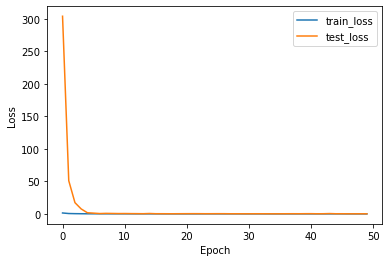

In [26]:
# Plotting Loss of RESNET model
metrics = history_relu.history
plt.plot(history_relu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plotting Accuracy of RESNET Model
plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

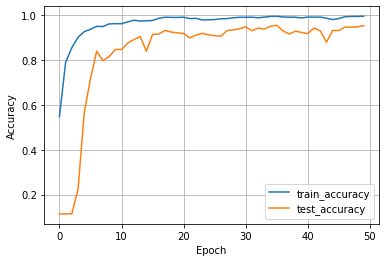

In [27]:
# Plotting Accuracy of RESNET Model

plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)